# Reporte de Copa KC Setiembre 2022

>Reporte de Mazos de la comunidad LATAM usados en la primera fase de la KC Cup en YuGiOh! Duel Links

![](https://s3.duellinksmeta.com/img/legacy-articles/content/tournaments/kc-cup/09/thumbnail-temp.jpg)


## Un poco de contexto
---
[Yu-Gi-Oh! Duel Links](https://www.konami.com/yugioh/duel_links/en/) es un videojuego de cartas coleccionables digital con mecánica free-to-play con microtransacciones desarrollado por Konami para Windows descargable con Steam, iOS y Android. Primero se lanza en Japón el 17 de noviembre de 2016 y se libera a nivel mundial el 11 de enero de 2017.
En el lore del juego, Seto Kaiba a través de su corporación crea una realidad virtual llamada "Duel World" para reunir a los mejores duelistas para que puedan competir donde a lo largo del tiempo acompañan los personajes de las diferentes sagas y spin-offs.

Por medio de ello realiza cada cierto tiempo la copa Kaiba Corporation para demostrar quien es el mejor duelista del planeta.


![](http://pa1.narvii.com/6911/6ae48b510a713f089f643bd060e681f37891bc52r1-540-540_00.gif)


Es un sistema de ranking que consta de 2 fases, en resumen la fase 1 recompensa gemas que son la moneda del juego y en la fase 2 da premio al 1er lugar para clasificar al mundial de yugioh pero no recompensa gemas. Por lo que la comunidad normalmente prioriza la fase 1 que te da recursos para la cuenta.


## Conociendo los datos

**1.  id**
registro único para identificar usuario.

**2.  usuario**
Es el jugador, en la base de datos es único y no deja reportar si jugó en varias cuentas, es criterio de exclusión de la base de datos si se reporta que jugó varias cuentas/decks.

**3.  deck**
Arquetipo usado.

**4.  skill**
Habilidad usada en el deck.

**5.  wins**
Total de victorias conseguidas en el mes reportado hasta el momento que llegó al ndmax, por eventos separados el juego no contabiliza.

**6.  ndmax**
Fecha que llegó al rango máximo.

**7.  Los booleanos**
Comprueba si el usuario compartió su deck en qué server en concreto.   
    - zerotg  = [ZeroTG](https://www.youtube.com/c/ZeroTG)   
    - zephra  = [ZephraCarl](https://www.youtube.com/c/ZephraCarl)   
    - bryan  = [Bryan Norén](https://www.youtube.com/c/BryanNorén)   
    - xenoblur  = [Xenoblur](https://www.youtube.com/c/XenoBlur)

## Pre-procesamiento de datos
---

Un poco de spam de código, **cargando datos...**

![](https://media.giphy.com/media/EXnmWXYei4pcMxkh8o/giphy.gif)

In [26]:
# Poniendo las librerías
from os.path import abspath
from pathlib import Path
import decouple
from datetime import datetime
import logging
import os
import pyprojroot
import requests as req
from sqlalchemy import create_engine as ce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import session_info

In [9]:
logging.basicConfig(
    format = '%(message)s', 
    level=logging.DEBUG,  
    encoding="utf-8"
    )

In [10]:
now = datetime.now()
today = now.strftime('%d-%m-%Y')

In [11]:
config = decouple.AutoConfig(' ')

In [14]:
pg_engine = ce(config('engine_psql'))
logging.info("Conexión exitosa.")

Conexión exitosa.


In [15]:
connection = pg_engine.raw_connection()
cursor = connection.cursor()
cursor.execute("SELECT version()")
row = cursor.fetchone()
logging.info("Versión del servidor de PostgreSQL: {}".format(row))

Versión del servidor de PostgreSQL: ('PostgreSQL 13.8, compiled by Visual C++ build 1914, 64-bit',)


In [16]:
with open(str(abspath('table_create.sql')), 'r', encoding='utf-8') as myfile:
            tc = myfile.read()
            cursor.execute(tc)
            logging.info("Tabla creada")

Tabla creada


In [17]:
files = Path(str(pyprojroot.here('report-days-sql'))).glob("*.sql")
for line in files:
        with open(line, 'r', encoding='utf-8') as insert_into:
            report_day = insert_into.read()
            cursor.execute(report_day)
            connection.commit()
logging.info(f'Registros insertados hasta el {str(today)}')

Registros insertados hasta el 12-06-2023


**Base de datos cargada**

![](https://media.giphy.com/media/zBlVtzQrpCU4OtSJb4/giphy.gif)

### Conteo de observaciones y variables

In [18]:
df = pd.read_sql("kcsep22", pg_engine)
logging.info(f'En total hay {df.shape[0]} usuarios registrados')

En total hay 362 usuarios registrados


In [20]:
df.sample(5)

,id,usuario,deck,skill,wins,ndmax,zerotg,zephra,bryan,xenoblur
78,82,3137,SuperHeavy Samurai,Evolución del Estilo,97.0,2022-09-10,True,False,False,False
39,31,8510,Abyss Actor,Tumbas Selladas,NaN,2022-09-08,True,True,True,False
275,287,2327,Tech Genus,Control de Vuelo,64.0,2022-09-15,False,True,False,False
302,310,8732,Synchrons,Camino de la Estrella Fugaz,45.0,2022-09-16,False,True,False,False
6,12,9851,Galaxy-Eyes,Galaxia XYZ,90.0,2022-09-07,True,False,False,False


## Visualización de los datos

### Registro de la comunidad

In [21]:
servers = ['zerotg', 'zephra', 'bryan', 'xenoblur']

In [98]:
cantidad = [int(df.zerotg.sum()), int(df.zephra.sum()), int(df.bryan.sum()), int(df.xenoblur.sum())]
for i in servers:
    df[i] = df[i].apply(lambda x: int(x))

comunidad = (
    pd.DataFrame(list(zip(servers, cantidad)), 
                 columns = ['Servers', 'Total'])
    .sort_values('Total', ascending=0)
)

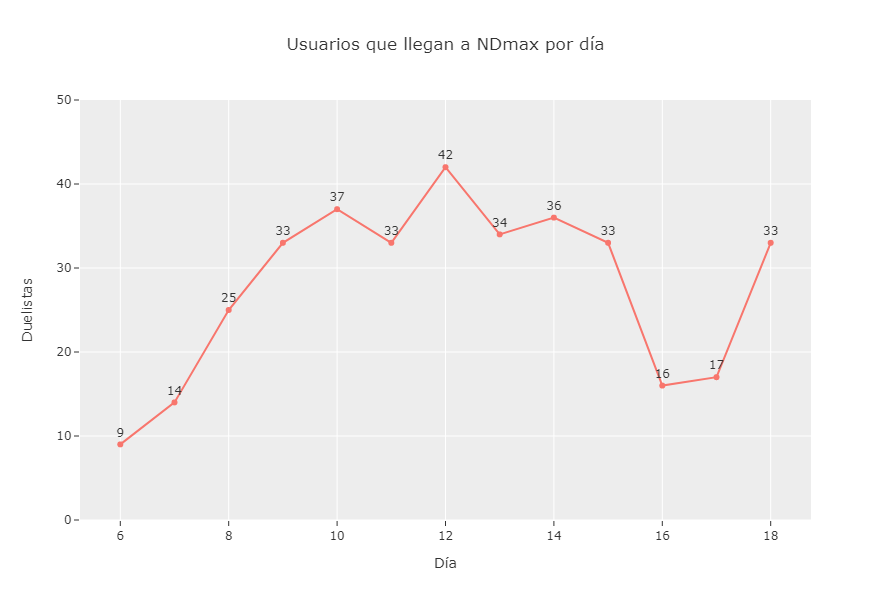

En promedio suelen tardar hasta el día 12 para llegar a ndMAX


In [36]:
df['Día'] = pd.DatetimeIndex(df['ndmax']).day

ndmax_fer_day = (
    df.groupby(['Día'])['Día'].count()
    .reset_index(name='Duelistas'))

fig = px.line(
    ndmax_fer_day, x="Día", y="Duelistas",
    title="Usuarios que llegan a NDmax por día", text="Duelistas", template='ggplot2')
fig.update_yaxes(range=[0, 50])
fig.update_traces(textposition="top center")
fig.update_layout(width=800, height=600)
fig.show()

logging.info(f'En promedio suelen tardar hasta el día {round(df.day.mean())} para llegar a ndMAX')

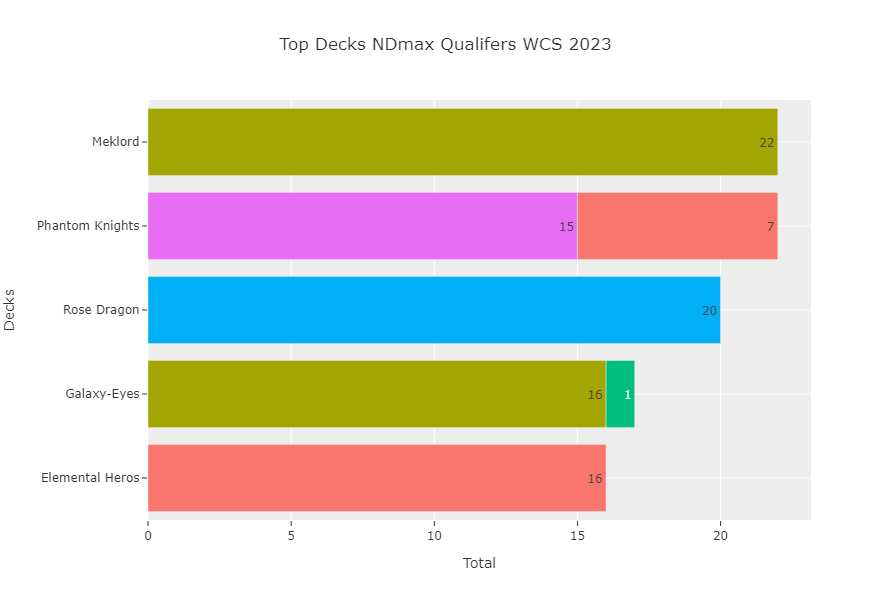

De 72 arquetipos distintos este el top 5


In [76]:
resume = (
    df.groupby(['deck','skill'])['skill'].size()
    .reset_index(name='total')
    .sort_values('total', ascending=0)
)

meklord = resume.query("deck=='Meklord'")
pecas = resume.query("deck=='Phantom Knights'")
rose_dragon = resume.query("deck=='Rose Dragon'")
galaxy_eyes = resume.query("deck=='Galaxy-Eyes'")
e_heros = resume.query("deck=='Elemental Heros'")

topfive=pd.concat([eheros, galaxy_eyes, rose_dragon, pecas, meklord], ignore_index=True)

fig = px.bar(topfive, y='deck', x="total", color="skill",
                title="Top Decks NDmax Qualifers WCS 2023", text="total", 
                orientation='h', template="ggplot2")
fig.update_layout(showlegend=False, width=800, height=600, xaxis_title="Total", yaxis_title="Decks")
fig.show()
logging.info(f'De {df["deck"].nunique()} arquetipos distintos este el top 5')

Tabla de todos los mazos que usan Robo del Destino


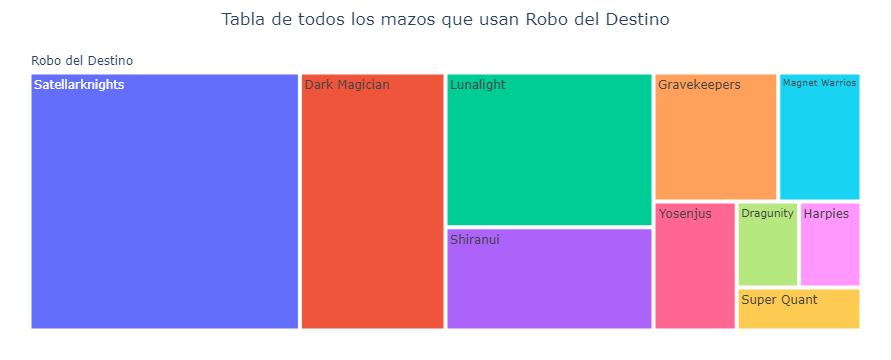

In [62]:
logging.info('Tabla de todos los mazos que usan Robo del Destino')

skill_df = (
    df.groupby(['deck','skill'])['skill'].size()
    .reset_index(name='total')
    .sort_values('deck', ascending=1)
)

fig = px.treemap(skill_df.query("skill=='Robo del Destino'"), path=['skill', 'deck'], values='total')
fig.update_layout(title='Tabla de todos los mazos que usan Robo del Destino', title_x=0.5,
                 margin = dict(t=50, l=25, r=25, b=25))
# Muestra el treemap
fig.show()

>Hace referencia al anime cuando en sus partidas difíciles Yugi roba la carta que necesita para ganar el duelo.   
![](https://i.imgur.com/UM1Fvc1.png)

![](https://c.tenor.com/DRn16ES_h-EAAAAC/yu-gi-oh-yami-yugi.gif)

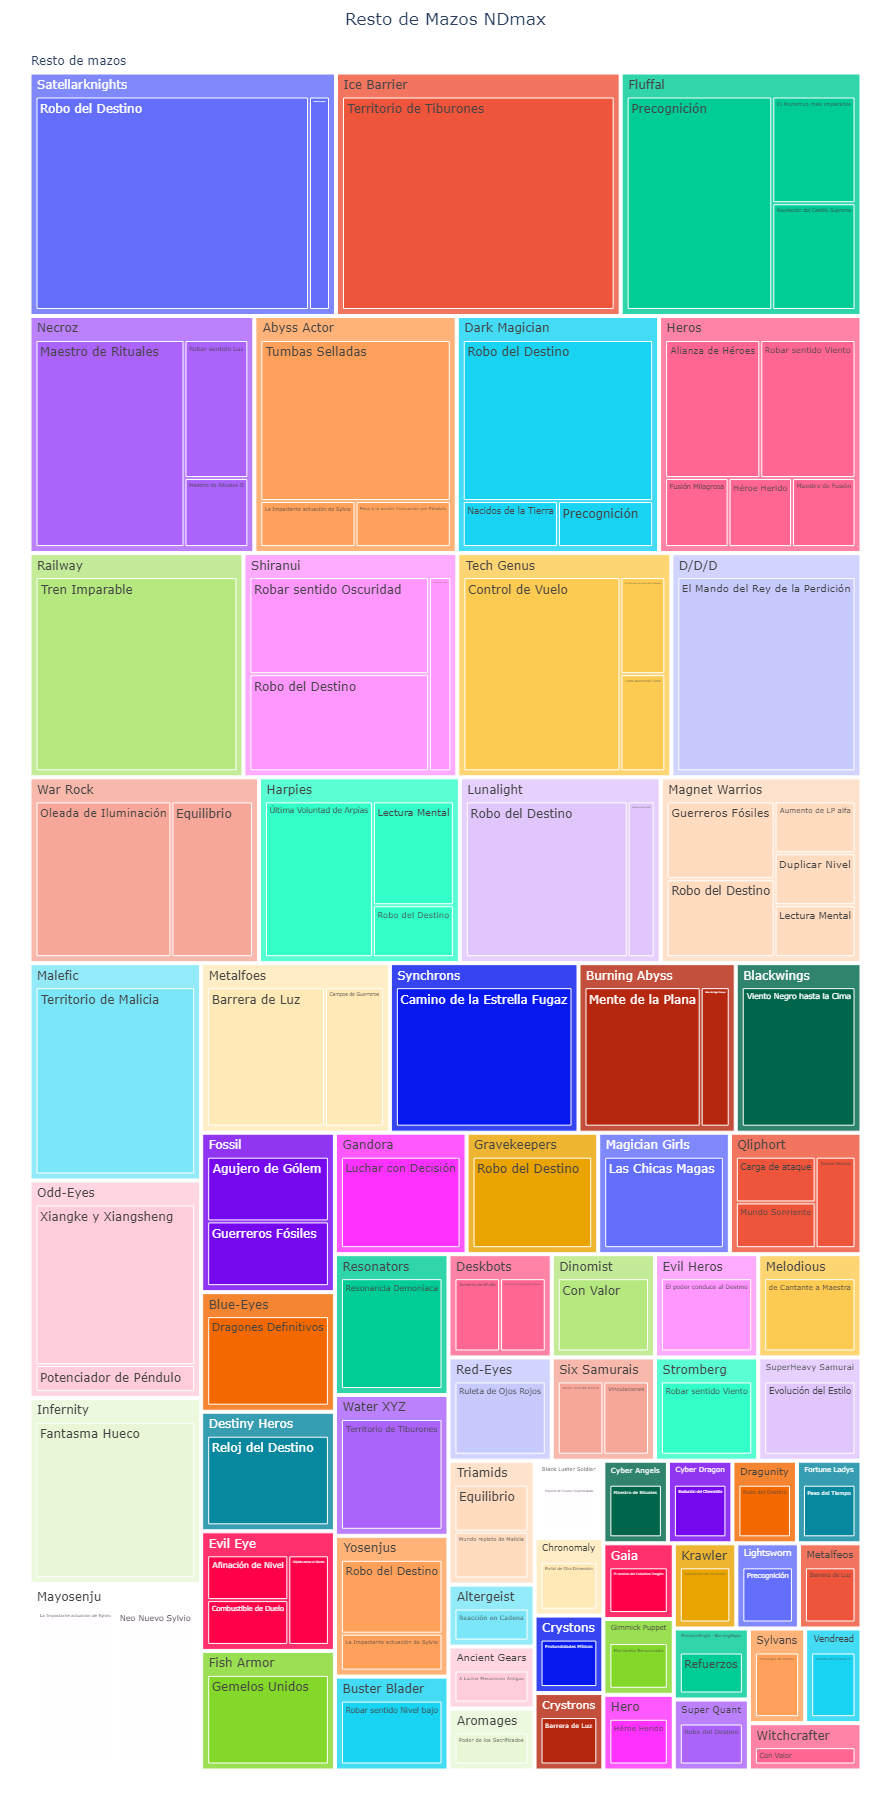

In [112]:
no_top_decks = resume.copy()
no_top_decks = no_top_decks.drop(no_top_decks[(no_top_decks['deck'] == "Meklord")
                    | (no_top_decks['deck'] == "Phantom Knights")
                    | (no_top_decks['deck'] == "Rose Dragon")
                    | (no_top_decks['deck'] == "Galaxy-Eyes")
                    | (no_top_decks['deck'] == "Elemental Heros")].index)

no_top_decks["all"] = "Resto de mazos"
fig = px.treemap(
    no_top_decks[['all', 'deck', 'skill', 'total']],
    path=['all', 'deck', 'skill'], values='total')
fig.update_layout(
    title='Resto de Mazos NDmax', title_x=0.5,
    margin = dict(t=50, l=25, r=25, b=25), width=900, height=1800)
fig.show()

In [29]:
pg_engine.dispose()
logging.info("Reporte finalizado, terminar conexión.")

Reporte finalizado, terminar conexión.


![](http://pa1.narvii.com/6411/55721509d05e50566c9077a912c78d9ab935111d_00.gif)

## Información de sesión
---

In [1]:
session_info.show()

NameError: name 'session_info' is not defined

![](https://pa1.narvii.com/6924/10a6261502508433f8e2500b86c6a9e820f83de0r1-443-247_hq.gif)